In [1]:
# import EDA libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
# Model
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

import time

In [2]:
#import the data
df = pd.read_csv('demand-forecasting.csv')
df['date'] = pd.to_datetime(df['date'])
print(df.head())
print(df.info())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


In [3]:
#Feature engineering: time related
def create_date_features(df):
    sg_holidays = holidays.Singapore()
    #week and dates
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quarter"] = df.date.dt.quarter
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    # seasons: 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    #holidays
    df['is_holiday'] =  df['date'].map(lambda x: int(x in sg_holidays))
    return df

In [4]:
#Apply the time related features
df = create_date_features(df)
df.head()

,date,store,item,sales,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,is_holiday
0,2013-01-01,1,1,13,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,1
1,2013-01-02,1,1,11,1,2,2,1,3,2013,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,14,1,3,3,1,4,2013,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,13,1,4,4,1,5,2013,1,1,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,10,1,5,5,1,6,2013,1,1,0,0,0,0,0,0,0,0


In [5]:
#check the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              913000 non-null  datetime64[ns]
 1   store             913000 non-null  int64         
 2   item              913000 non-null  int64         
 3   sales             913000 non-null  int64         
 4   month             913000 non-null  int32         
 5   day_of_month      913000 non-null  int32         
 6   day_of_year       913000 non-null  int32         
 7   week_of_year      913000 non-null  UInt32        
 8   day_of_week       913000 non-null  int32         
 9   year              913000 non-null  int32         
 10  is_wknd           913000 non-null  int32         
 11  quarter           913000 non-null  int32         
 12  is_month_start    913000 non-null  int32         
 13  is_month_end      913000 non-null  int32         
 14  is_q

In [6]:
#train and test split
def train_test_split(data):
    X = data.drop(['sales', 'date'], axis = 1)
    y = data['sales']
    X_train = X[data['date'] <= '2017-09-30']
    y_train = y[data['date'] <= '2017-09-30']
    X_test = X[data['date'] > '2017-09-30']
    y_test = y[data['date'] > '2017-09-30']
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(df)
print(f"Shape of X_train: {X_train.shape}\nShape of y_train: {y_train.shape}\nShape of X_test: {X_test.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (867000, 18)
Shape of y_train: (867000,)
Shape of X_test: (46000, 18)
Shape of y_test: (46000,)


Random Forest

In [25]:
# Try to use all default values to run the model
rftree = RandomForestRegressor(random_state=42, oob_score=True)

#time calculate
start_time = time.time()
rftree.fit(X_train, y_train)
end_time = time.time()    

# calculate the training time
training_time = end_time - start_time

#predict
y_pred = rftree.predict(X_test)

#smape function
def smape(actual, forecast):
    return 100 / len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))
# evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
smape_value = smape(y_test, y_pred)
print("R-squared: ", r2)
print("Root of Mean Squared Error: ", rmse)
print(f'SMAPE: {smape_value:.2f}%')

#check result
print("OOB Score: ", round(rftree.oob_score_,3))
print("Score on Trainset:", round(rftree.score(X_train, y_train),3))
print("Score on Testset:", round(rftree.score(X_test, y_test),3)) #predict on test
print("Training time:", training_time)

R-squared:  0.9110898589614046
Root of Mean Squared Error:  8.493791323411012
SMAPE: 13.71%
OOB Score:  0.919
Score on Trainset: 0.989
Score on Testset: 0.911
Training time: 360.7067358493805


In [8]:
#Features important table of random forest
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":rftree.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

            Features  Importance
1               item    0.565531
0              store    0.158590
16            season    0.082983
7               year    0.047767
4        day_of_year    0.043282
6        day_of_week    0.042118
3       day_of_month    0.019147
8            is_wknd    0.019091
5       week_of_year    0.012953
2              month    0.004682
9            quarter    0.002029
17        is_holiday    0.000789
11      is_month_end    0.000396
10    is_month_start    0.000378
12  is_quarter_start    0.000125
13    is_quarter_end    0.000115
15       is_year_end    0.000012
14     is_year_start    0.000012
0.9999999999999999


XGBoost

In [9]:
#Try default set
xgbc = XGBRegressor(random_state = 42)
start_time = time.time()
xgbc.fit(X_train, y_train)
end_time = time.time()
y_pred = xgbc.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
smape_value = smape(y_test, y_pred)
training_time = end_time - start_time

print("R-squared: ", r2)
print("Root of Mean Squared Error: ", rmse)
print(f'SMAPE: {smape_value:.2f}%')
print("Score on Trainset:", round(xgbc.score(X_train, y_train),3))
print("Score on Testset :", round(xgbc.score(X_test, y_test),3))
print("Training time:", training_time)

R-squared:  0.9193829746140989
Root of Mean Squared Error:  8.087966097307334
SMAPE: 13.31%
Score on Trainset: 0.93
Score on Testset : 0.919
Training time: 1.218095302581787


In [10]:
#Features important table of xgboost
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":xgbc.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

            Features  Importance
16            season    0.290934
1               item    0.270449
0              store    0.112974
2              month    0.091682
5       week_of_year    0.080331
6        day_of_week    0.077775
7               year    0.059985
4        day_of_year    0.013704
3       day_of_month    0.000802
15       is_year_end    0.000436
13    is_quarter_end    0.000275
12  is_quarter_start    0.000235
17        is_holiday    0.000233
14     is_year_start    0.000183
11      is_month_end    0.000000
10    is_month_start    0.000000
8            is_wknd    0.000000
9            quarter    0.000000
1.0000000567379175


In [26]:
#Try to find the best combination of parameters of xgboost
#xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the range of parameters
param_distributions = {
    'n_estimators': randint(50, 500),          
    'max_depth': randint(3, 10),               
    'learning_rate': uniform(0.01, 0.3),       
    'subsample': uniform(0.5, 0.9),            
    'colsample_bytree': uniform(0.5, 0.9),     
    'gamma': uniform(0, 0.5),                  
    'reg_alpha': uniform(0, 1),                
    'reg_lambda': uniform(0.1, 2)              
}

#Set RMSE as the evaluation target of random search
scorer = make_scorer(mean_squared_error, squared=False)

# Set random search
random_search = RandomizedSearchCV(estimator=xgb_reg, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,       # 搜索100次随机组合
                                   scoring= scorer,  # 使用RMSE作为评分指标
                                   cv=5,             # 5折交叉验证
                                   verbose=2, 
                                   random_state=42,
                                   n_jobs=-1)        


random_search.fit(X_train, y_train)

#Best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

#predict
y_pred = best_model.predict(X_test)

#evaluation
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
smape_value = smape(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape_value:.2f}%")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'colsample_bytree': 0.7953374007272587, 'gamma': 0.0775208083638721, 'learning_rate': 0.3045522664931593, 'max_depth': 8, 'n_estimators': 363, 'reg_alpha': 0.8604046183116753, 'reg_lambda': 0.6005027210317281, 'subsample': 0.5349512609864808}
R-squared: 0.9185737338173807
RMSE: 8.128458592031436
SMAPE: 13.42%


In [27]:
#Overfitting check
print("Score on Trainset:", round(best_model.score(X_train, y_train),3))
print("Score on Testset :", round(best_model.score(X_test, y_test),3))

Score on Trainset: 0.941
Score on Testset : 0.919


In [31]:
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
print(end_time - start_time)

5.232943534851074


In [28]:
#Features important table of best xgboost model
fimpt = pd.DataFrame({"Features": X_train.columns, "Importance":best_model.feature_importances_})
fimpt.sort_values("Importance", ascending=False, inplace=True)
print(fimpt)
print(sum(fimpt['Importance']))# adds up to 1.0

            Features  Importance
16            season    0.555890
1               item    0.159773
0              store    0.066919
8            is_wknd    0.057234
2              month    0.045486
7               year    0.039147
6        day_of_week    0.037214
9            quarter    0.013352
5       week_of_year    0.009136
4        day_of_year    0.006586
12  is_quarter_start    0.001474
13    is_quarter_end    0.001265
3       day_of_month    0.001251
17        is_holiday    0.001157
11      is_month_end    0.001107
10    is_month_start    0.001045
14     is_year_start    0.001012
15       is_year_end    0.000950
0.9999999976716936


In [14]:
#Descover the score and training time based on the tree depth
rmse_values = []
smape_values = []
training_times = []
n_estimators_range = np.arange(50, 501, 50)

for n in n_estimators_range:
    xgbc = XGBRegressor(n_estimators=n, random_state=42)
    
    # start time
    start_time = time.time()    
    xgbc.fit(X_train, y_train)    
    # end time
    end_time = time.time()    
    # calculate the training time
    training_time = end_time - start_time
    training_times.append(training_time)
    
    # predict
    y_pred = xgbc.predict(X_test)    
    
    # Calculate RMSE and SMAPE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_value = smape(y_test, y_pred)
    
    
    rmse_values.append(rmse)
    smape_values.append(smape_value)

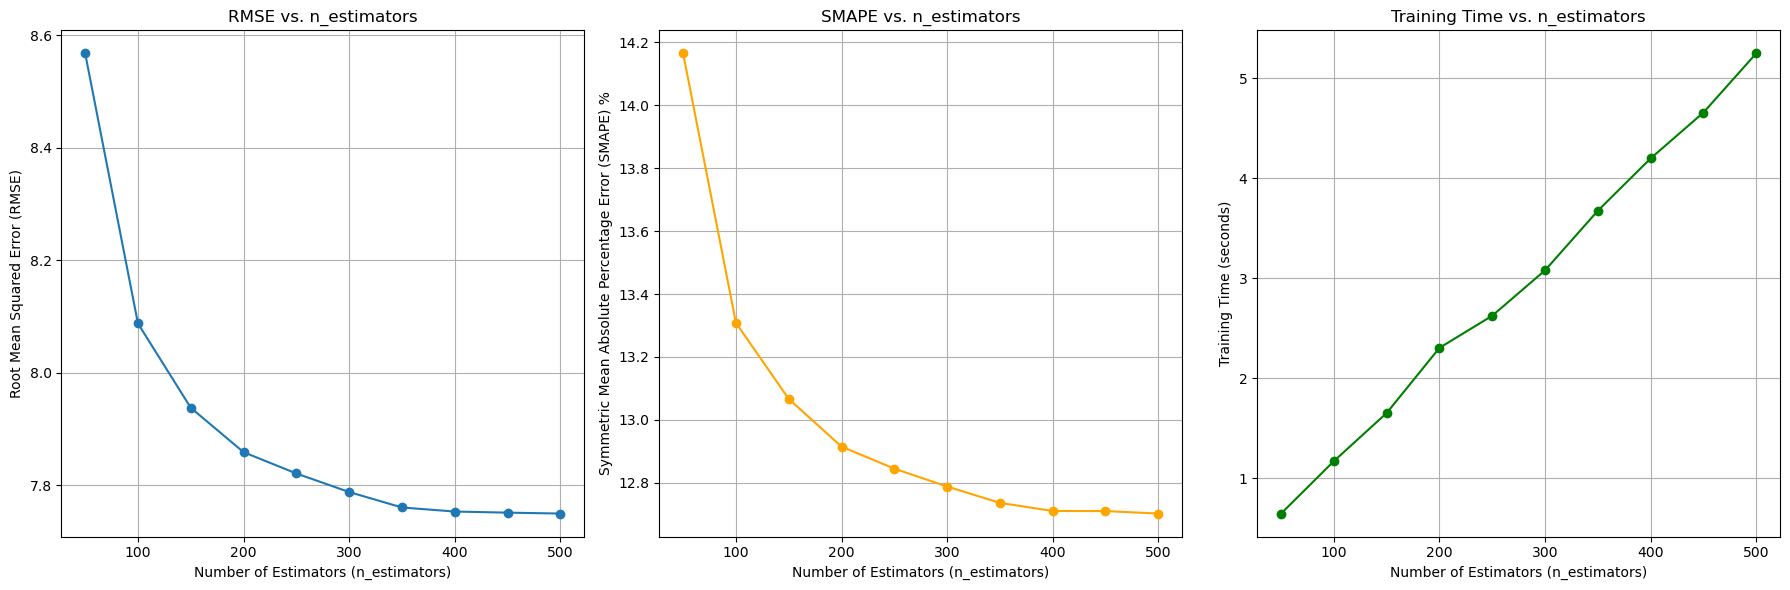

Final Results with n_estimators =  500
Final RMSE:  7.750006530633519
Final SMAPE:  12.701974390222396
Training Time:  5.249251365661621 seconds
R-squared on Trainset: 0.938
R-squared on Testset : 0.926


In [15]:
#plot: xlabel as depth of trees
plt.figure(figsize=(18, 6))

# RMSE
plt.subplot(1, 3, 1)
plt.plot(n_estimators_range, rmse_values, marker='o')
plt.title('RMSE vs. n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid()

# SMAPE
plt.subplot(1, 3, 2)
plt.plot(n_estimators_range, smape_values, marker='o', color='orange')
plt.title('SMAPE vs. n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Symmetric Mean Absolute Percentage Error (SMAPE) %')
plt.grid()

# Training time
plt.subplot(1, 3, 3)
plt.plot(n_estimators_range, training_times, marker='o', color='green')
plt.title('Training Time vs. n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Training Time (seconds)')
plt.grid()

plt.tight_layout()
plt.show()

# final result
print("Final Results with n_estimators = ", n_estimators_range[-1])
print("Final RMSE: ", rmse_values[-1])
print("Final SMAPE: ", smape_values[-1])
print("Training Time: ", training_times[-1], "seconds")
print("R-squared on Trainset:", round(xgbc.score(X_train, y_train), 3))
print("R-squared on Testset :", round(xgbc.score(X_test, y_test), 3))

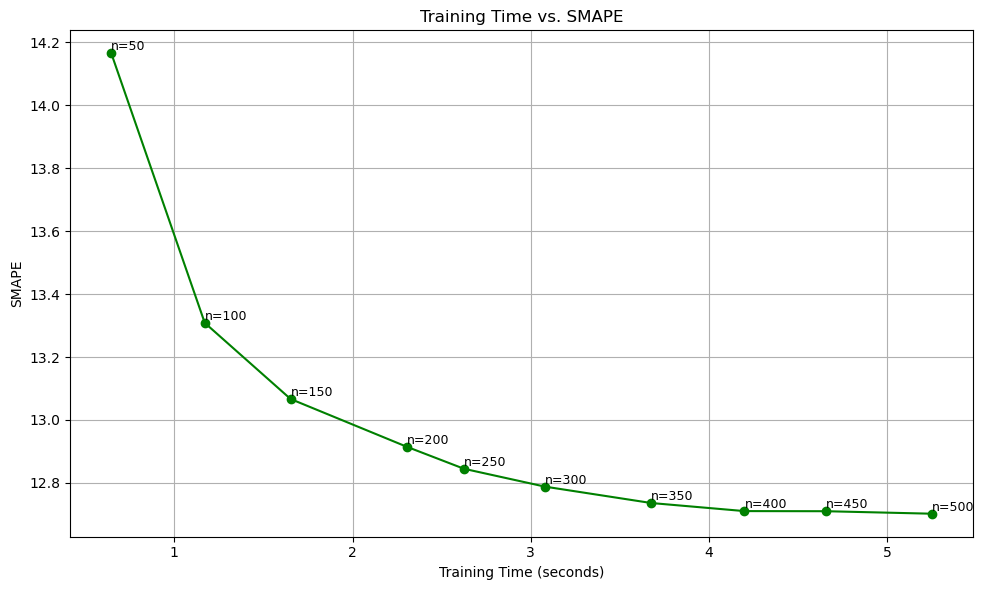

In [16]:
#Compared SMAPE and training time 
plt.figure(figsize=(10, 6)) 
plt.plot(training_times, smape_values, marker='o', color='green')
plt.title('Training Time vs. SMAPE')
plt.xlabel('Training Time (seconds)')
plt.ylabel('SMAPE')
plt.grid()

# labels
for i, txt in enumerate(n_estimators_range):
    plt.text(training_times[i], smape_values[i], f'n={txt}', fontsize=9, ha='left', va='bottom')



plt.tight_layout()
plt.show()


In [17]:
#考虑把未来三个月的结果做出来分析展示？

In [30]:
ideal_model = XGBRegressor(n_estimators=250, random_state=42)
start_time = time.time()
ideal_model.fit(X_train, y_train)
end_time = time.time()
y_pred = ideal_model.predict(X_test)
y_pred.reshape(-1,1)
y_pred = list(y_pred)
print(len(y_pred))
print(end_time - start_time)

46000
2.2641804218292236


In [32]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
smape_value = smape(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"SMAPE: {smape_value:.2f}%")
print("Score on Trainset:", round(ideal_model.score(X_train, y_train),3))
print("Score on Testset :", round(ideal_model.score(X_test, y_test),3))

R-squared: 0.9246114847680693
RMSE: 7.8212925811692955
SMAPE: 12.84%
Score on Trainset: 0.936
Score on Testset : 0.925


In [19]:
df_2013 = df[df['year'] == 2013].groupby('day_of_year')['sales'].mean()
df_2013

day_of_year
1      27.392
2      27.356
3      28.976
4      31.354
5      32.474
        ...  
361    34.094
362    36.866
363    38.296
364    25.916
365    30.088
Name: sales, Length: 365, dtype: float64

In [20]:
y_test

1734      21
1735      12
1736      18
1737      15
1738      20
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 46000, dtype: int64

In [21]:
#Calculate the original cost on unfulfillment of the sales if not using the best model
# 按年份提取销售数据
sales_data = df.copy()
store_ids = range(1, 11)  # 商店ID: 1到10
item_ids = range(1, 51)   # 商品ID: 1到50
# 创建一个用于存储预测的 DataFrame
# 创建一个用于存储预测的 DataFrame
# 初始化一个空的 DataFrame 来存储预测结果
predictions_df = pd.DataFrame(columns=['date', 'store', 'item', 'predicted_sales'])

# 进行销售额预测
for store in store_ids:
    for item in item_ids:
        # 提取该商店该商品的销售数据
        filtered_data = sales_data[(sales_data['store'] == store) & (sales_data['item'] == item)]
        
        # 确保数据中包含2013年到2016年的数据
        if not filtered_data[filtered_data['year'] < 2017].empty:
            # 获取对应年份的销售额
            sales_2013 = filtered_data[filtered_data['year'] == 2013].set_index('day_of_year')['sales']
            sales_2014 = filtered_data[filtered_data['year'] == 2014].set_index('day_of_year')['sales']
            sales_2015 = filtered_data[filtered_data['year'] == 2015].set_index('day_of_year')['sales']
            sales_2016 = filtered_data[filtered_data['year'] == 2016].set_index('day_of_year')['sales']
            
            # 预测2017年剩下三个月的销售额
            for month in range(10, 13):  # 10月到12月
                # 获取每个月的天数
                if month == 10:  # 10月有31天
                    days_in_month = 31
                elif month == 11:  # 11月有30天
                    days_in_month = 30
                else:  # 12月有31天
                    days_in_month = 31
                
                for day in range(1, days_in_month + 1):  # 从1到该月的最大天数
                    # 计算预测的销售额
                    predicted_sales = (
                        sales_2013.get(day, 0) * 0.1 +
                        sales_2014.get(day, 0) * 0.2 +
                        sales_2015.get(day, 0) * 0.3 +
                        sales_2016.get(day, 0) * 0.4
                    )
                    
                    # 将预测结果添加到 DataFrame
                    new_row = pd.DataFrame({
                        'date': [pd.Timestamp(year=2017, month=month, day=day)],
                        'store': [store],
                        'item': [item],
                        'predicted_sales': [predicted_sales]
                    })
                    predictions_df = pd.concat([predictions_df, new_row], ignore_index=True)

# 查看结果
predictions_df.head(100) # 查看前100行预测结果

,date,store,item,predicted_sales
0,2017-10-01,1,1,14.8
1,2017-10-02,1,1,14.8
2,2017-10-03,1,1,13.2
3,2017-10-04,1,1,14.3
4,2017-10-05,1,1,13.4
...,...,...,...,...
95,2017-10-04,1,2,31.9
96,2017-10-05,1,2,34.3
97,2017-10-06,1,2,32.9
98,2017-10-07,1,2,37.7


In [22]:
predictions_df['ideal'] = y_pred
predictions_df['true_sales'] = y_test.values
predictions_df

,date,store,item,predicted_sales,ideal,true_sales
0,2017-10-01,1,1,14.8,26.280197,21
1,2017-10-02,1,1,14.8,19.461515,12
2,2017-10-03,1,1,13.2,21.109997,18
3,2017-10-04,1,1,14.3,20.957899,15
4,2017-10-05,1,1,13.4,22.954592,20
...,...,...,...,...,...,...
45995,2017-12-27,10,50,40.1,57.269836,63
45996,2017-12-28,10,50,48.3,63.057667,59
45997,2017-12-29,10,50,47.2,68.086594,74
45998,2017-12-30,10,50,53.6,71.651909,62


In [24]:
cost_predicted_sales = abs(predictions_df.predicted_sales - predictions_df.true_sales) * 0.05
cost_ideal_model_sales = abs(predictions_df.ideal - predictions_df.true_sales) * 0.05
save = cost_predicted_sales - cost_ideal_model_sales
save_percentage = save/cost_predicted_sales
print(f"Save amount: {save.sum():.2f}")
print(f"Save percentage: {smape_value:.2f}%")

Save amount: 51811.11
Save percentage: 12.70%
